# A/B Testing for Price Analytics

The goal of work is to glean actionable insight from an A/B test data to determine the effects of increasing the price of a software product.

This work tackles the following 3 questions:
1. What impact does increasing the software price have on the conversion rate?
2. What impact does increasing the software price have on the total revenue?
3. What additional insights from the data could be use to retain or increase conversion rate ?



In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use("ggplot")
from sklearn.preprocessing import OneHotEncoder

# Data Exploration

In [2]:
def data_preprocessing(data_path):
    """
    :param data_path: the path to the uncleaned data
    :returns : cleaned dataframe
    """
    # Load the data
    test_users_data = pd.read_csv(data_path)
    #drop Unnamed column
    test_users_data.drop(columns =["Unnamed: 0"], inplace= True)
    #Rename the column name
    test_users_data.rename(columns={"operative_system":"operating_system"}, inplace=True)
    #Drop any duplicate rows
    test_users_data.drop_duplicates(subset = ["user_id"], inplace = True)
    #correct typos
    test_users_data["source"] = test_users_data["source"].str.replace("-","_")
    test_users_data["operating_system"] = test_users_data["operating_system"].fillna("others")
    test_users_data["operating_system"] = test_users_data["operating_system"].str.replace("i0S","iOS")
    test_users_data["operating_system"] = test_users_data["operating_system"].str.replace("wnddows","windows")
    test_users_data["operating_system"] = test_users_data["operating_system"].str.replace("apple","mac")
    test_users_data["operating_system"] = test_users_data["operating_system"].str.replace("anroid","android")
    test_users_data["timestamp"] = test_users_data["timestamp"].str.replace("60","59")
    test_users_data["timestamp"] = test_users_data["timestamp"].str.replace("2815","2015")
    #Convert string datetime to datetime object
    test_users_data["timestamp"] = pd.to_datetime(test_users_data["timestamp"])
    #Drop missing columns for timestamp and source columns
    test_users_data.dropna(subset=["timestamp"], inplace = True)
    test_users_data.dropna(subset=["source"], inplace = True)
    #Only select two prices for the software: $39 and $59
    test_users_data = test_users_data[test_users_data["price"]<=59.00]

    return test_users_data

# Exploratory Data Analysis

Given 3 months user data collected by randomly presenting users with either the normal software price or the increased software price. The users that recieved the normal price are the **control group**, while the users that recieved the increased software price are the **test group**.

In [3]:
#Load data
# 3 months worth of data (~ 90 days)
data_path = "./data/test_user_data.csv"
#get cleaned data
test_users_data = data_preprocessing(data_path)

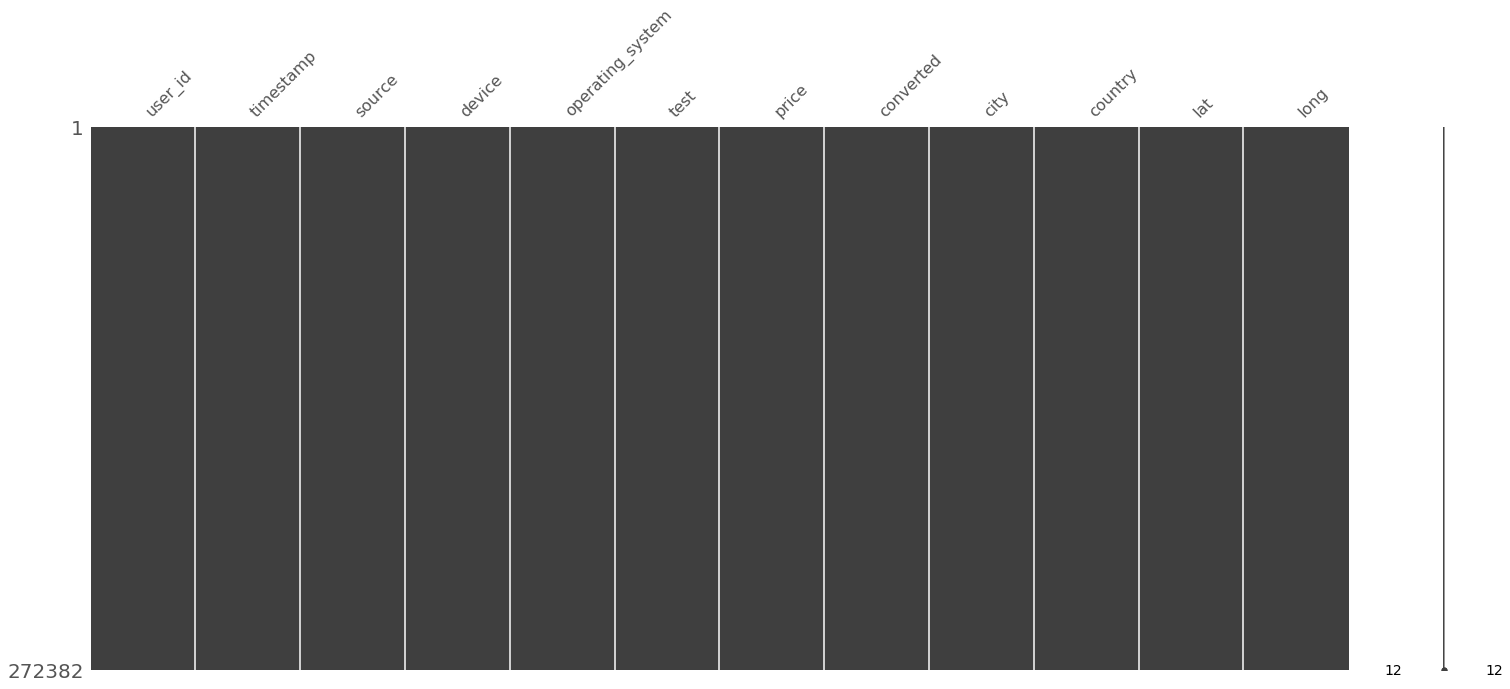

In [4]:
#Visualization of the cleaned data
msno.matrix(test_users_data)

The figure above shows that there are no missing values in the cleaned data.

In [5]:
# Encoding the categorical variables
encode_device = {'mobile':0, 'web':1}
encode_os ={'iOS':0, 'android':1, 'mac':2, 'windows':3, 'others':4}
encode_source = {'ads_facebook':0, 'seo_google':1, 'ads_bing':2, 'direct_traffic':3,
       'ads_google':4, 'friend_referral':5, 'ads_yahoo':6,
       'seo_yahoo':7, 'seo_facebook':8, 'seo_bing':9, 'seo_other':10,'ads_other':11}
test_users_data["source"].replace(encode_source, inplace=True)
test_users_data["device"].replace(encode_device, inplace=True)
test_users_data["operating_system"].replace(encode_os, inplace=True)

In [6]:
# split data into test and control sets
test_group = test_users_data[test_users_data["price"]==59.00]
control_group = test_users_data[test_users_data["price"]==39.00]

Let's dig deep and explore the test and the control group to ensure that there are comparable time, sources, devices, and operating systems  distributions

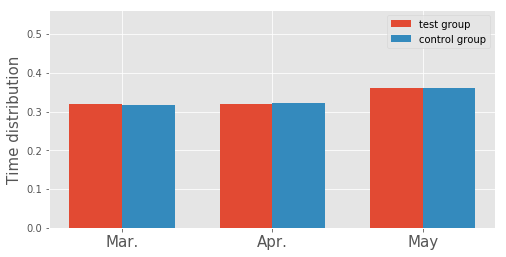

In [7]:
time_dist_by_month_test = test_group["timestamp"].groupby(test_group["timestamp"].dt.month).count()
time_dist_by_month_control = control_group["timestamp"].groupby(control_group["timestamp"].dt.month).count()
time_dist_by_month_test = time_dist_by_month_test/sum(time_dist_by_month_test)
time_dist_by_month_control = time_dist_by_month_control/sum(time_dist_by_month_control)

ind = np.arange(3)
width = .35
figsize = (8,4)
fig = plt.figure(figsize =figsize)
ax = fig.add_subplot(111)
ax.bar(ind,time_dist_by_month_test,width=width, label="test group")
ax.bar(ind+width,time_dist_by_month_control,width=width, label="control group")
ax.set_xticks(ind+width/2)
fontsize = 15
plt.ylabel("Time distribution",fontsize=fontsize )
ax.set_xticklabels(labels=["Mar.", "Apr.", "May"], fontsize = fontsize)
ylim0 = max(max(time_dist_by_month_test), max(time_dist_by_month_control))
ax.set_ylim([0.00, ylim0+0.2])
ax.legend()

In [8]:
def encoder(cat_var):
    """
    :param cat_var: numerical categorical variable column
    """
    oneHot = OneHotEncoder(categories="auto",sparse=False)
    cat_var = cat_var.dropna()
    cat_var = cat_var.values.reshape(len(cat_var),1)# encoder needs 2D array
    return oneHot.fit_transform(cat_var)

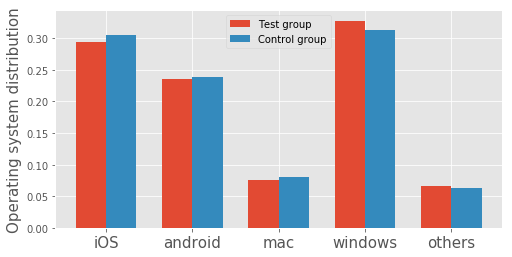

In [9]:
oneHot_test = encoder(test_group["operating_system"])
oneHot_test = oneHot_test.sum(axis=0)/oneHot_test.sum()
oneHot_control = encoder(control_group["operating_system"])
oneHot_control = oneHot_control.sum(axis=0)/oneHot_control.sum()

figsize = (8,4)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ind = np.arange(len(oneHot_test))
width = .35
ax.bar(ind,oneHot_test, width= width, label="Test group")
ax.bar(ind+width,oneHot_control, width= width, label="Control group")
ax.set_xticks(ind+width/2)
fontsize = 15
plt.ylabel("Operating system distribution", fontsize=fontsize)
ax.set_xticklabels(labels=list(encode_os.keys()), fontsize=fontsize)
plt.legend()

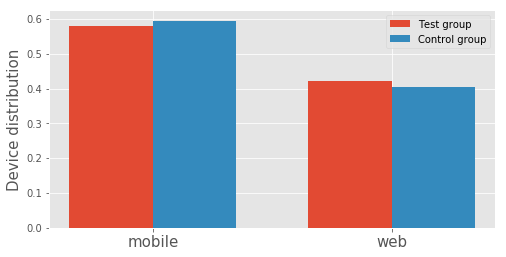

In [10]:
oneHot_test = encoder(test_group["device"])
oneHot_test = oneHot_test.sum(axis=0)/oneHot_test.sum()
oneHot_control = encoder(control_group["device"])
oneHot_control = oneHot_control.sum(axis=0)/oneHot_control.sum()

figsize = (8,4)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ind = np.arange(len(oneHot_test))
width = .35
ax.bar(ind,oneHot_test, width= width, label="Test group")
ax.bar(ind+width,oneHot_control, width= width, label="Control group")
ax.set_xticks(ind+width/2)
fontsize = 15
plt.ylabel("Device distribution", fontsize=fontsize)
ax.set_xticklabels(labels=list(encode_device.keys()), fontsize=fontsize)
plt.legend()

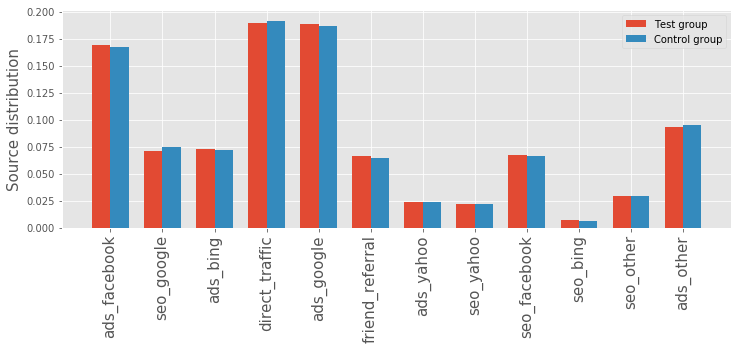

In [11]:
oneHot_test = encoder(test_group["source"])
oneHot_test = oneHot_test.sum(axis=0)/oneHot_test.sum()
oneHot_control = encoder(control_group["source"])
oneHot_control = oneHot_control.sum(axis=0)/oneHot_control.sum()

figsize = (12,4)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ind = np.arange(len(oneHot_test))
width = .35
ax.bar(ind,oneHot_test, width= width, label="Test group")
ax.bar(ind+width,oneHot_control, width= width, label="Control group")
ax.set_xticks(ind+width/2)
fontsize = 15
plt.ylabel("Source distribution", fontsize=fontsize)
ax.set_xticklabels(labels=list(encode_source.keys()), fontsize=fontsize, rotation=90)
plt.legend()

The test and control group split seem to have a similar distribution. So there is no obvious systematic bias.

# Testing impact of increasing the software price 

### Conversion rate difference

We would like to understand whether or not the conversion rate decreased for test group relative to control group.
This can be framed as a large sample hypothesis testing problem for two binomial proportions.

<br>
> $H_0$ (null hypothesis): The conversion rate is the same for both the test and the control groups
<br>
> $H_a$ (alternative): The conversion rate is NOT the same for both the test and the control groups
<br>

We compute a normal approximation test that the difference between the two proportions is equal to zero.

In [12]:
# calculate convertion prob
N_test = test_group["converted"].count()
N_control = control_group["converted"].count()
conv_prob_test = test_group[test_group["converted"]==1]["converted"].count()/N_test
conv_prob_control = control_group[control_group["converted"]==1]["converted"].count()/N_control
percent_decrease = (conv_prob_control-conv_prob_test)/conv_prob_control
percent_decrease

0.2153163413315359

The conversion rate changed by approximately 22% for the test group relative to the control group.

In [13]:
joint_prob = (N_test*conv_prob_test+ N_control*conv_prob_control)/(N_test+N_control)
print("Joint prob: ",joint_prob)
joint_var = joint_prob*(1-joint_prob)*(1/N_test +1/N_control)
print("Joint var: ",joint_var)
Ztest_stats = (conv_prob_control-conv_prob_test)/np.sqrt(joint_var)
Ztest_stats
pvalue = 1- stats.norm.cdf(abs(Ztest_stats))
print("p value: ",pvalue)

Joint prob:  0.01822807674515937
Joint var:  2.8519123102931294e-07
p value:  7.771561172376096e-16


Since the p-value is very low (<1%), we reject the null hypothesis that the conversion is the same for both the test and the control group with 99% confidence. 

### Revenue differece 

We would like to understand how the revenue is affected; specifically whether or not the revenue increased for test group relative to control group. This can be framed as a large sample hypothesis testing problem for two binomial proportions.
<br>
> $H_0$ (null hypothesis): The total revenue is the same for both the test and the control groups
<br>
> $H_a$ (alternative): The total revenue is NOT the same for both the test and the control groups
<br>

We compute a normal approximation test that the difference between the two proportions is equal to zero.

In [14]:
obs_rev_test = 59.00*conv_prob_test
obs_rev_control = 39.00*conv_prob_control


joint_prob_rev = (N_test*obs_rev_test+ N_control*obs_rev_control)/(N_test+N_control)
print("Joint prob: ",joint_prob_rev)
joint_var_rev = joint_prob_rev*(1-joint_prob_rev)*(1/N_test +1/N_control)
print("Joint var: ",joint_var_rev)
Ztest_stats = (obs_rev_control-obs_rev_test)/np.sqrt(joint_var_rev)
Ztest_stats
pvalue = 1- stats.norm.cdf(abs(Ztest_stats))
print("p value: ",pvalue)
percent_increase = (obs_rev_test-obs_rev_control)/obs_rev_test
percent_increase

Joint prob:  0.8225029554082134
Joint var:  2.3265548985622147e-06
p value:  0.0


0.157600719920398

The revenue seem to increase 16% for the test group relative to the control group.

# Customer Insight
Let's try to identify what customers we lose as a result of increasing the price of the software product. Perhaps by identifying those customers we could better target them and incentivize them with promotion.

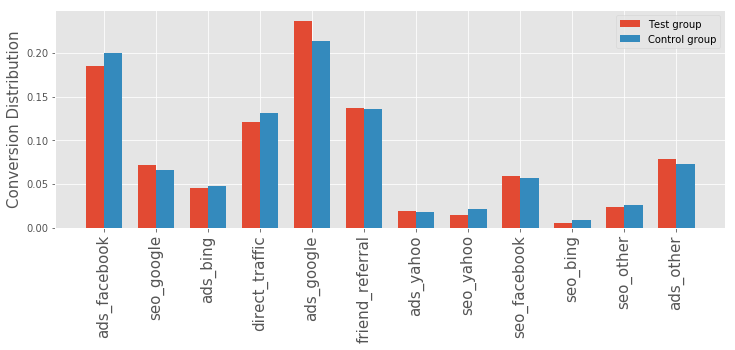

In [15]:
test_group_conv = test_group[test_group["converted"]==1]
control_group_conv =control_group[control_group["converted"]==1]
oneHot_test = encoder(test_group_conv["source"])
oneHot_test = oneHot_test.sum(axis=0)/oneHot_test.sum()
oneHot_control = encoder(control_group_conv["source"])
oneHot_control = oneHot_control.sum(axis=0)/oneHot_control.sum()

figsize = (12,4)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ind = np.arange(len(oneHot_test))
width = .35
ax.bar(ind,oneHot_test, width= width, label="Test group")
ax.bar(ind+width,oneHot_control, width= width, label="Control group")
ax.set_xticks(ind+width/2)
fontsize = 15
plt.ylabel("Conversion Distribution", fontsize=fontsize)
ax.set_xticklabels(labels=list(encode_source.keys()), fontsize=fontsize, rotation=90)
plt.legend()

The figure above shows that in the test group, the users sourced through google are more likely to convert than the users sourced through Facebook. Of course, one should perform hypothesis testing to see if this difference is significant.

# Insights

- **The increase in the price of the software negatively affected the conversion rate**. Increasing the software price by \$20 over three months results in a decrease in the conversion rate by 22\%.

- **The increase in the price of the software positively affected the total revenue**. By increasing the software price by $20 over three months, results in an increase in the net revenue per user by 16% relative to control group.

- **Incentive program could help retain conversion rate under the new software price**.  For the test group, the number of conversion from google ads increased while the number of conversion from facebook ads decreased. Perhaps, an incentive programs might help maintain the conversion rate from facebook ads. Moreover, we could also explore the possibility of increasing google ads campaign to reach potential new customers.
